# Zadanie
Zadanie polega na własnoręcznym zaimplementowaniu algorytmu k-means. Algorytm powinien być zaimplementowany w oparciu o bibliotekę `Numpy`. Podczas implementacji nie wolno korzystać z bibliotek typu `sklearn`, które mają ten algorytm wbudowany. Dopuszczalne jest natomiast wykorzystywanie tego rodzaju bibliotek w celach porównawczych, do sprawdzenia czy nasz algorytm działa poprawnie. Ocenie podlega rozwiązanie i odpowiedź.


- Zaimplementuj `K-means` w przestrzeni dwuwymiarowej (każdy punkt ma dwie współrzędne). - *(dostateczny)*
- Zmniejsz problem związany z 'utknięciem' w lokalnym optimum poprzez wywołanie algorytmu 100 razy i wybranie rozwiązania z najmniejszą funkcją kosztu - *(dostateczny plus)*
- Zwizualizuj wyniki na wykresie - *(dobry)*
- Rozszerz swoją implementację o `K-means++` lub zmień ją tak by działała w n-wymiarowej przestrzeni - *(bardzo dobry)*

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd

Przykładowy kod do generowania punktów

In [3]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))

Przykładowy kod do wyświetlenia wygenerowanych punktów

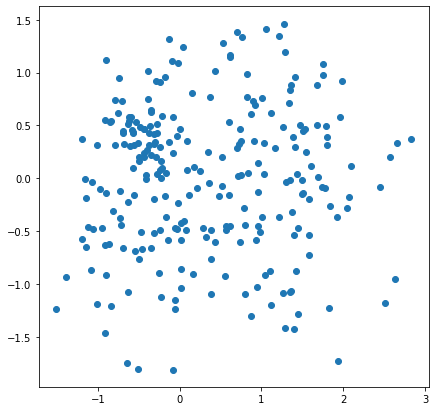

In [4]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(points[:, 0], points[:, 1])
ax = plt.gca()

In [5]:
points.shape[1]

2

Implementacja algorytmu **K-means** oraz **K-means++** za pomocą klasy `myKmeans`.

####Przebieg algorytmu K-means:
1. Ustalenie losowo centroidów ze zbioru danych. Stworzenie pustej tablicy centroidów jest poprzez odrówcenie tablicy 'points'. Po wykonaniu pętli mamy wymiary features x clusters gdzie każda kolumna jest centroidem dla jednego klustera.
2. Dla każdego punktu ze zbioru danych musimy obliczyć `euclidian_distance` od centroidy i przypisać klaster na podstawie odległości, która jest najmniejsza.
3. Znalezione odległości eukildesowe (tj. od każdego punktu do wszystkich centroidów) są zapisane w macierzy, gdzie każdy wiersz zawiera odległość danego punktu od wszystkich centroid.
4. Następnie na podstawie `minimum` przeprowadza się grupowanie punktów ze zbioru danych - dopasowanie do danego klastera.
5. Zwracany jest dziennik, w któym keys będą oznaczać numer klastra, a values przyporządkowane punkty do danego klastra.


####Przebieg algorytmu K-means++:
1. Losowy wybór centroidy pierwszego klastra z punktów i dodanie jej do tablicy `centroids_kpp`.
2. Przejść za pomocą pętli tyle razy ile potrzebujemy centroidów (tj. liczba kalstrów)
3. Dla każdego punktu obliczyć kwadrat odległości euklidesowej z wybranej centroidy i dołączyć najmniejszą odległość do tablicy `distance`.
4. Obliczyć prawdopodbieństwo `prob_distribution` tego, że zostanie wybrany konkretny punkt jako nastepny centroid poprzez podzielenie elementów tablicy przez sumę odległości w tablicy.
5. Obliczyć prawdopodbieństwo skumulowane `cum_probability`.
6. Wylosować liczbę z zakresu od 0 do 1 oraz ustalić indeks ze skumulowanego rozkładu prawdopopdbieństwa, gdzie wartość jest odrobinę większa niż wylosowana liczba.
7. Wybrać punkt z danych znajdujący się pod ustalonym indeksem z punktu wcześniejszego.
8. Powtarzać tą czynność dla wszystkich klasterów.

In [6]:
class myKmeans:
  def __init__(self, data, clusters):
    self.data = data
    self.clusters = clusters
    self.output_kmeans = {}
    self.samples_number = self.data.shape[0]
    self.features_number = self.data.shape[1]
    self.centroids = np.array([]).reshape(self.features_number,0)

  def kmeans_pp(self,data, clusters):
    index = rd.randint(0, data.shape[0])
    centroids_kpp = np.array([data[index]])

    for cluster in range(1, clusters):
      distance = np.array([])
      
      for point in data:
        min_euclidian_distance = np.min(np.sum((point - centroids_kpp)**2))
        distance = np.append(distance, min_euclidian_distance)

      prob_distribution = distance/np.sum(distance)
      cum_probabilty = np.cumsum(prob_distribution)

      random = rd.random()
      index = 0

      for position, probability in enumerate(cum_probabilty):
        if random < probability:
          index = position
          break
      
      centroids_kpp = np.append(centroids_kpp, [data[index]],axis=0)

    return centroids_kpp.T


  def fit(self,iterations, kpp):

    if kpp:
      self.centroids = self.kmeans_pp(self.data, self.clusters)
    else:
      for i in range(self.clusters):
        random_point = rd.randint(0,self.samples_number-1)
        self.centroids = np.c_[self.centroids, self.data[random_point]]
    

    for i in range(iterations):
      euclidian_distance = np.array([]).reshape(self.samples_number, 0)

      for cluster in range(self.clusters):
        current_distance=np.sum((self.data-self.centroids[:,cluster])**2,axis=1)
        euclidian_distance = np.c_[euclidian_distance, current_distance]
      
      minimum = np.argmin(euclidian_distance, axis=1)+1

      cluster_dic = {}
      
      for cluster in range(self.clusters):
        cluster_dic[cluster+1] = np.array([]).reshape(self.features_number,0)
      
      for i in range(self.samples_number):
        cluster_dic[minimum[i]] = np.c_[cluster_dic[minimum[i]], self.data[i]]
      
      for cluster in range(self.clusters):
        cluster_dic[cluster+1] = cluster_dic[cluster+1].T
      
      for cluster in range(self.clusters):
        self.centroids[:,cluster] = np.mean(cluster_dic[cluster+1], axis=0) # don't forget: wybieranie kolumny przez advanced indexing  z numpy!
      
      self.output_kmeans = cluster_dic
    
  def predict(self):
    return self.output_kmeans, self.centroids.T

  def WCSS(self):
      wcss=0
      for k in range(self.clusters):
          wcss+=np.sum((self.output_kmeans[k+1]-self.centroids[:,k])**2)
      return wcss

Zdefiniowanie zmiennych globalnych:


*   `DATA` - zawierajaca wcześniej wygenerowane punkty
*   `ITERATIONS` - liczba iteracji

Po metodzie ELBOW zostanie zdefiniowana kolejna zmienna globalna:
* `CLUSTERS` - liczba oznaczająca ilość klastrów (oznacza to również liczbę centroidów, które pojawią się wokół danych)



In [42]:
DATA = points;
ITERATIONS=100

Aby wybrać optymalną tj. najlepszą wartość dla parametru odpowiadajacego za liczbę klasterów wykorzystuje się metodę **ELBOW.**

Metoda ELBOW składa się z:
1. Wykonanie algorytmu K-means z przyjmowaniem różnych wartości klasterów od 1 do wybranej granicy.
2. Dla każdego K oblicza się WCSS *(Within-Cluster Sums of Squares)* , czyli sumę kwadratów odległości każdego punktu danych we wszystkich klastrach do ich odpowiednich centroid.
3. Wyrysowanie wykresu, na którym zostaną zaznaczone wartości WCSS dla każdej liczby klastrów.
4. Należy odczytać z wykresu wartość K, dla którego tempo spadku WCSS jest małe.

In [43]:
WCSS_array=np.array([])
for K in range(1,11):
    kmeans=myKmeans(DATA,K)
    kmeans.fit(ITERATIONS,0)
    Output,Centroids=kmeans.predict()
    WCSS_array=np.append(WCSS_array,kmeans.WCSS())

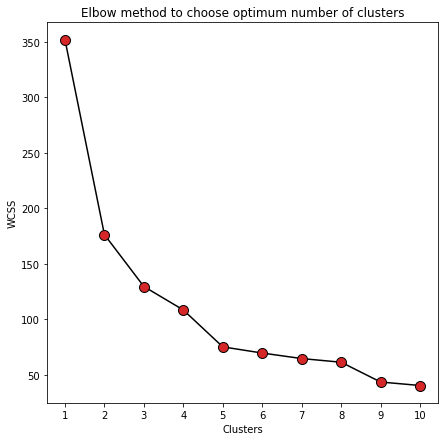

In [44]:
K_array=np.arange(1,11,1)

fig = plt.figure(figsize=(7, 7))

plt.plot(K_array, WCSS_array,
         color='black',
         marker='o',
         markerfacecolor = 'tab:red',
         markersize=10)
plt.xticks(K_array)
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to choose optimum number of clusters')
plt.show()

In [52]:
CLUSTERS=5

In [53]:
kmeans=myKmeans(DATA,CLUSTERS)
kmeans.fit(ITERATIONS, kpp=0)
Output,Centroids=kmeans.predict()

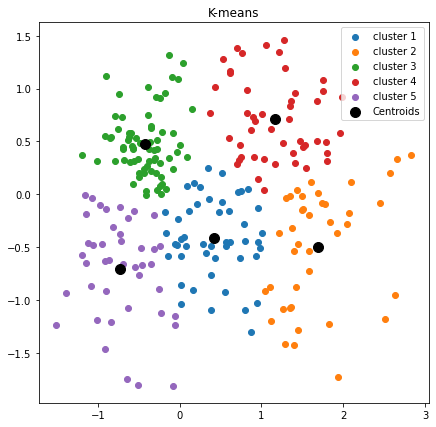

In [55]:
labels=['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5']
cmap = plt.get_cmap("tab20c")

fig = plt.figure(figsize=(7, 7))

for k in range(CLUSTERS):
    plt.scatter(Output[k+1][:,0],
                Output[k+1][:,1],
                cmap=cmap,
                label=labels[k])
    
plt.scatter(Centroids[:,0],
            Centroids[:,1],
            s=100,
            c='black',
            label='Centroids')

plt.title('K-means')
plt.legend()
plt.show()

Wywołanie działania algorytmu k-means z biblioteki sklearn dla porównania z przygotowaną wyżej implementacją

##Sklearn

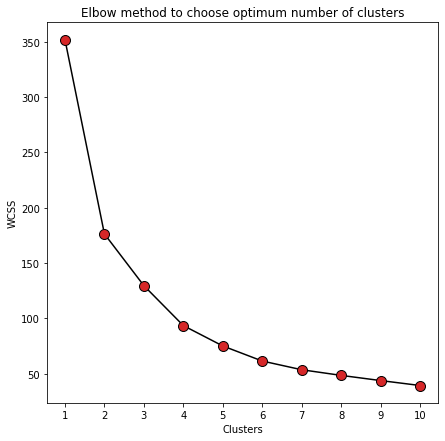

In [56]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(DATA)
    wcss.append(kmeans.inertia_)



fig = plt.figure(figsize=(7, 7))
plt.plot(K_array, wcss,
         color='black',
         marker='o',
         markerfacecolor = 'tab:red',
         markersize=10)

plt.xticks(K_array)
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to choose optimum number of clusters')
plt.show()

In [57]:
kmeans = KMeans(n_clusters = CLUSTERS, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(DATA)

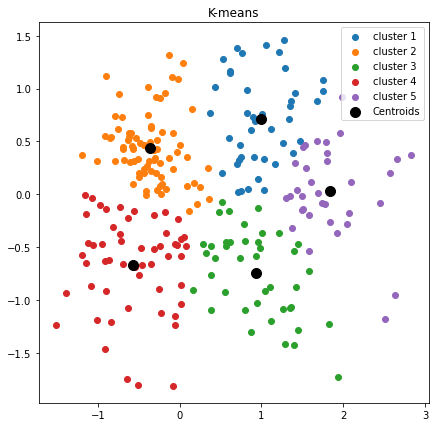

In [58]:
labels=['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5']
cmap = plt.get_cmap("tab20c")

fig = plt.figure(figsize=(7, 7))

for k in range(CLUSTERS):
    plt.scatter(DATA[y_kmeans== k,0],
                DATA[y_kmeans== k,1],
                cmap=cmap,
                label=labels[k])
    
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            s=100,
            c='black',
            label='Centroids')

plt.title('K-means')
plt.legend()
plt.show()

## K-means++

In [68]:
WCSS_array=np.array([])
for K in range(1,11):
    kmeans=myKmeans(DATA,K)
    kmeans.fit(ITERATIONS, kpp=1)
    Output,Centroids=kmeans.predict()
    WCSS_array=np.append(WCSS_array,kmeans.WCSS())

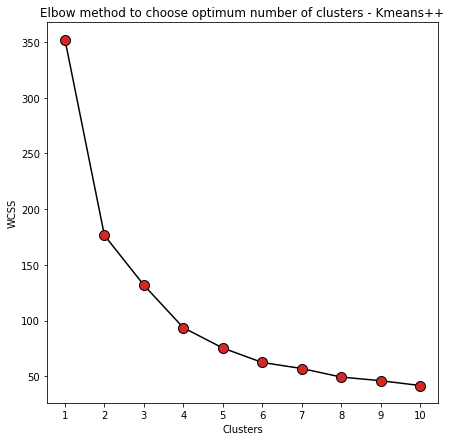

In [69]:
K_array=np.arange(1,11,1)

fig = plt.figure(figsize=(7, 7))

plt.plot(K_array, WCSS_array,
         color='black',
         marker='o',
         markerfacecolor = 'tab:red',
         markersize=10)
plt.xticks(K_array)
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to choose optimum number of clusters - Kmeans++')
plt.show()

In [ ]:
CLUSTERS = 5

In [70]:
kmeans=myKmeans(DATA,CLUSTERS)
kmeans.fit(ITERATIONS,kpp=1)
Output,Centroids=kmeans.predict()

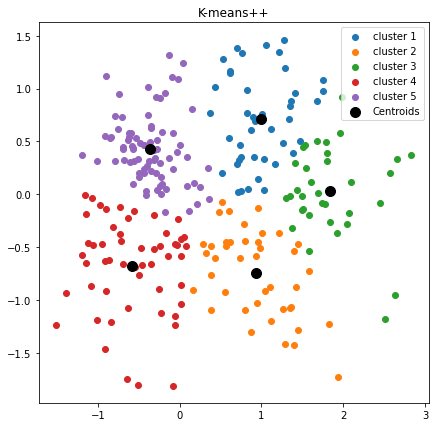

In [72]:
labels=['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5']
cmap = plt.get_cmap("tab20c")

fig = plt.figure(figsize=(7, 7))

for k in range(CLUSTERS):
    plt.scatter(Output[k+1][:,0],
                Output[k+1][:,1],
                cmap=cmap,
                label=labels[k])
    
plt.scatter(Centroids[:,0],
            Centroids[:,1],
            s=100,
            c='black',
            label='Centroids')

plt.title('K-means++')
plt.legend()
plt.show()